In [1]:
import numpy as np
from scipy.interpolate import interp1d
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kernels
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

In [2]:
plt.style.use('/home/jarmijo/pltstyle.mplstyle')

In [3]:
V0_fid = np.load('/lustre/work/jarmijo/data/HSC_NG/mean_MFs/mean_V0_fid_z1_allsmooth.npy')
V1_fid = np.load('/lustre/work/jarmijo/data/HSC_NG/mean_MFs/mean_V1_fid_z1_allsmooth.npy')
V2_fid = np.load('/lustre/work/jarmijo/data/HSC_NG/mean_MFs/mean_V2_fid_z1_allsmooth.npy')

In [4]:
def emulator_GP(sim_array, params, normalize=True):

    kernel = kernels.RBF(length_scale=  6.1,  length_scale_bounds= 'fixed')#
    gp_all = []
    
    for ibin in range(sim_array.shape[-1]):
        model = sim_array[:,ibin].T
        gpc = GaussianProcessRegressor(
                kernel=kernel, n_restarts_optimizer=10000,
                normalize_y=normalize, copy_X_train=False)        
        
        gpc.fit(params, model)


        gp_all.append(gpc)

        def interp_cosmo (params_test):
            gen_ps = lambda ibin: gp_all[ibin].predict(np.array(params_test).reshape(1, -1))
            gpinterp = list(map(gen_ps, range(sim_array.shape[-1])))
            gpinterp = np.array(gpinterp).reshape(-1,1).squeeze()
            return gpinterp
    return interp_cosmo


In [5]:
#load cosmological parameters
Om_S8 = np.loadtxt('/home/jarmijo/ng_likelihood_moped/omegam_sigma8_design3.dat')
param_test = Om_S8[:,(1,2)]

In [6]:
#load cosmovaried simulations
V0_zbins_thetas = []
V1_zbins_thetas = []
V2_zbins_thetas = []
for i in range(4):#redshift
    theta_gather_V0 = []
    theta_gather_V1 = []
    theta_gather_V2 = []
    for j in range(6): #smoothing scales    
        allmodels = np.load('/lustre/work/jarmijo/data/HSC_NG/moped_input/V0_HSC_z%d_theta%d_allmodels.npy'%(i+1,j+1))
        theta_gather_V0.append(allmodels)
        allmodels = np.load('/lustre/work/jarmijo/data/HSC_NG/moped_input/V1_HSC_z%d_theta%d_allmodels.npy'%(i+1,j+1))
        theta_gather_V1.append(allmodels)
        allmodels = np.load('/lustre/work/jarmijo/data/HSC_NG/moped_input/V2_HSC_z%d_theta%d_allmodels.npy'%(i+1,j+1))
        theta_gather_V2.append(allmodels)
    V0_zbins_thetas.append(theta_gather_V0)
    V1_zbins_thetas.append(theta_gather_V1)
    V2_zbins_thetas.append(theta_gather_V2)

In [7]:
V0_zbins_thetas = np.array(V0_zbins_thetas)
V1_zbins_thetas = np.array(V1_zbins_thetas)
V2_zbins_thetas = np.array(V2_zbins_thetas)

# zbin = 1

In [8]:
snedges = np.linspace(-4,4,20)
sn_bins = snedges[:-1] + np.diff(snedges)[0]/2.

In [9]:
zbin = 0
V0_z_thetas = []
V1_z_thetas = []
V2_z_thetas = []
for theta in range(6):
    
    V0_z1_theta1_pred = np.zeros((len(param_test),19))
    V1_z1_theta1_pred = np.zeros((len(param_test),19))
    V2_z1_theta1_pred = np.zeros((len(param_test),19))
    for i in range(len(param_test)):
        cosmo_i = param_test[i]
        cosmos_bool = (param_test == cosmo_i).all(axis=1)
        #
        V0_z_theta = V0_zbins_thetas[zbin,theta,~cosmos_bool,:]
        emu_test = emulator_GP(V0_z_theta,params=param_test[~cosmos_bool])
        V0_z1_theta1_pred[i] = emu_test(cosmo_i)
        #
        V1_z_theta = V1_zbins_thetas[zbin,theta,~cosmos_bool,:]
        emu_test = emulator_GP(V1_z_theta,params=param_test[~cosmos_bool])
        V1_z1_theta1_pred[i] = emu_test(cosmo_i)
        #
        V2_z_theta = V2_zbins_thetas[zbin,theta,~cosmos_bool,:]
        emu_test = emulator_GP(V2_z_theta,params=param_test[~cosmos_bool])
        V2_z1_theta1_pred[i] = emu_test(cosmo_i)
        
    V0_z_thetas.append(V0_z1_theta1_pred)        
    V1_z_thetas.append(V1_z1_theta1_pred)
    V2_z_thetas.append(V2_z1_theta1_pred)

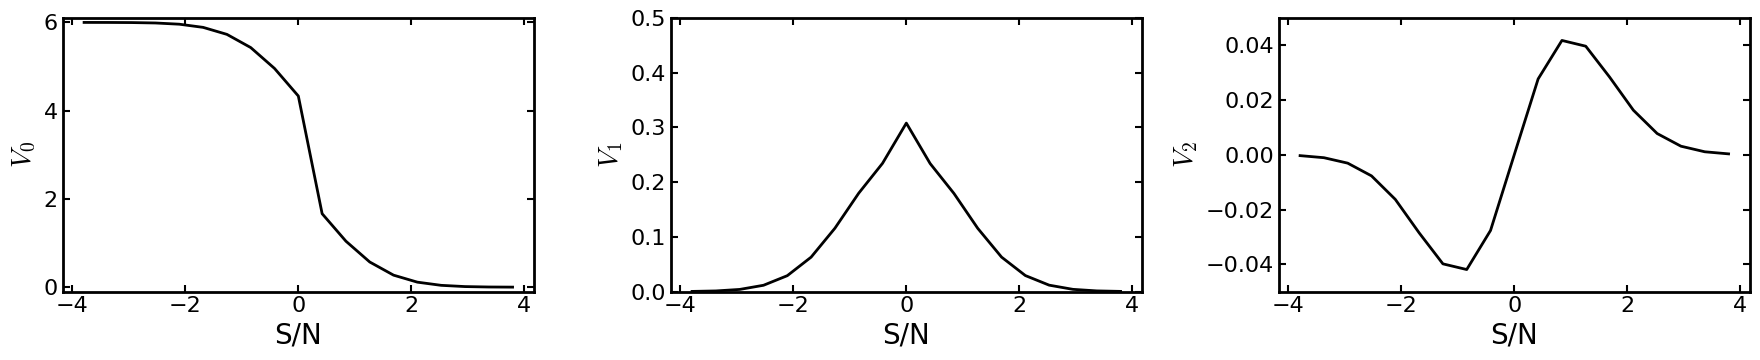

In [19]:
#
f,ax = plt.subplots(1,3,figsize=(18,4),sharex=True,sharey=False)
ax[0].plot(sn_bins,V0_fid[0],'k-',lw=2)
ax[1].plot(sn_bins,V1_fid[0],'k-',lw=2)
ax[2].plot(sn_bins,V2_fid[0],'k-',lw=2)
ax[0].set_ylim(-0.1,6.1)
ax[1].set_ylim(0.0,0.5)
ax[2].set_ylim(-0.05,0.05)
ax[0].set_ylabel(r'$V_0$')
ax[1].set_ylabel(r'$V_1$')
ax[2].set_ylabel(r'$V_2$')
ax[0].set_xlabel('S/N')
ax[1].set_xlabel('S/N')
ax[2].set_xlabel('S/N')

plt.tight_layout()
#plt.savefig('/home/jarmijo/plots/MFs_V0_V1_V2.jpg',bbox_inches='tight')
plt.show()



In [10]:
S8 = param_test[:,1]*np.sqrt(param_test[:,0]/0.3)
c = S8
c_i = (c - c.min())/(c.max()-c.min())
norm_i = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())

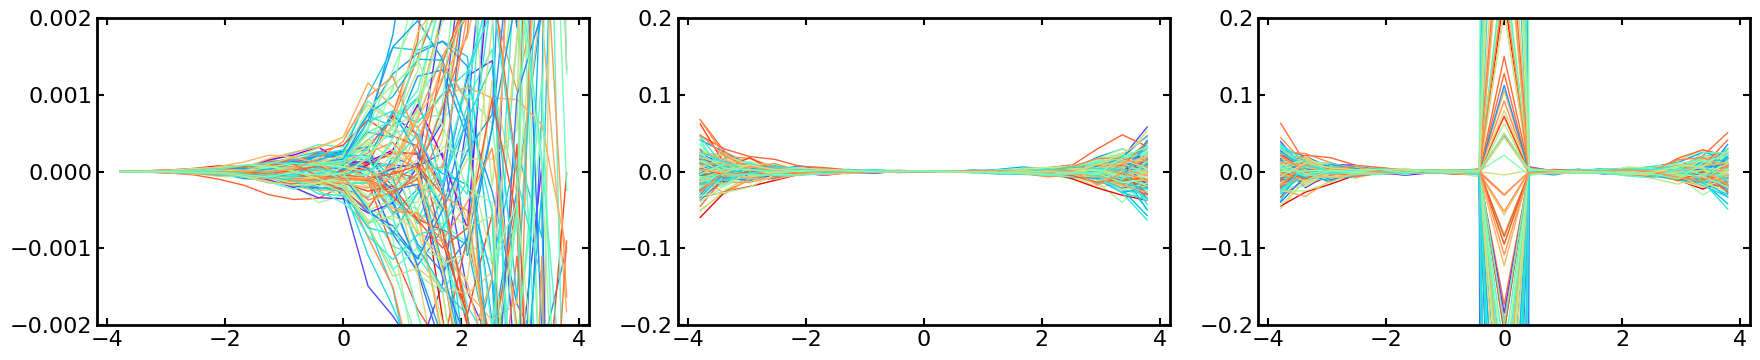

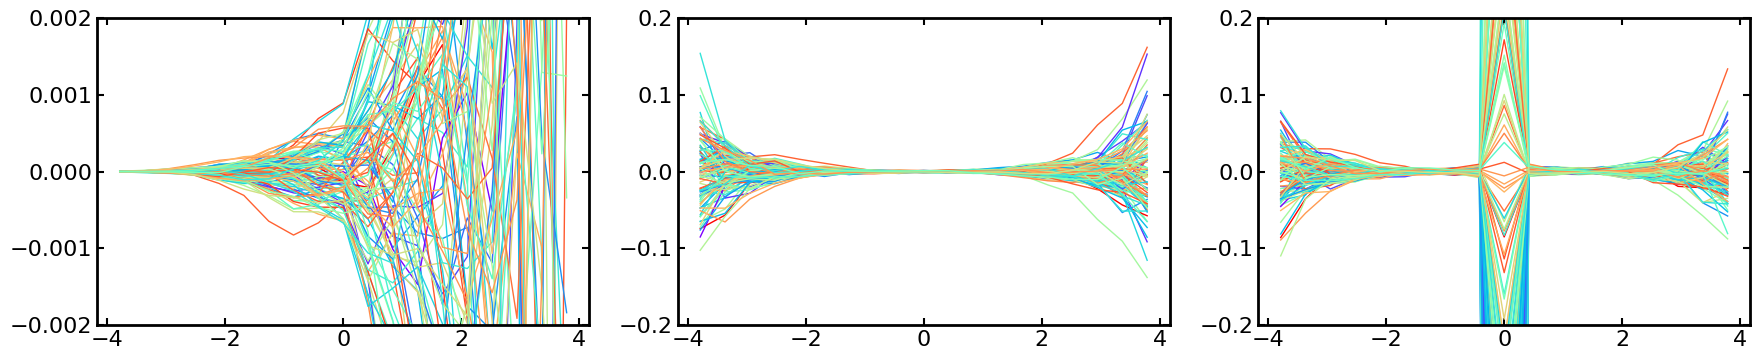

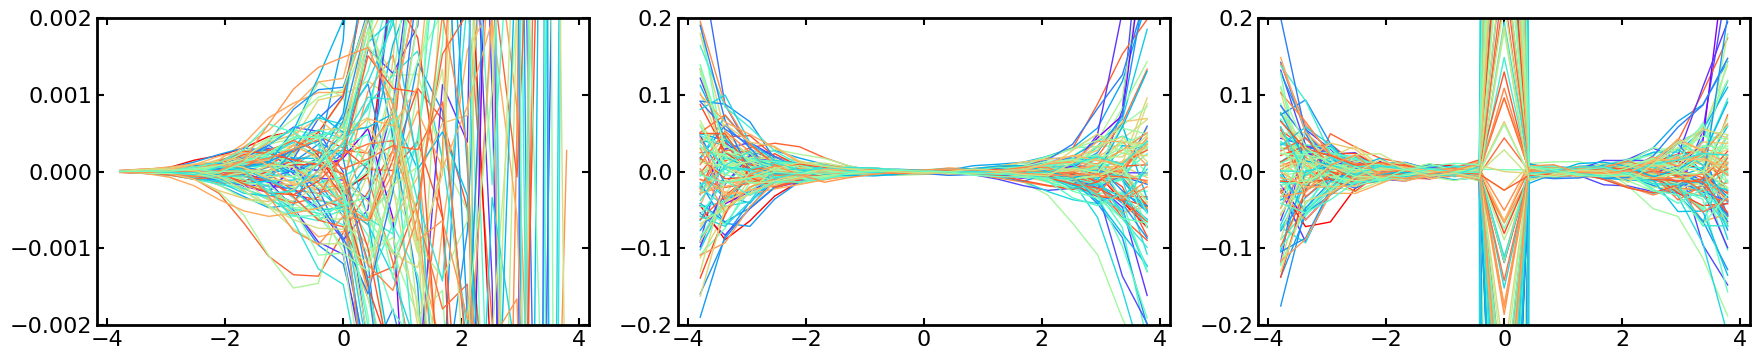

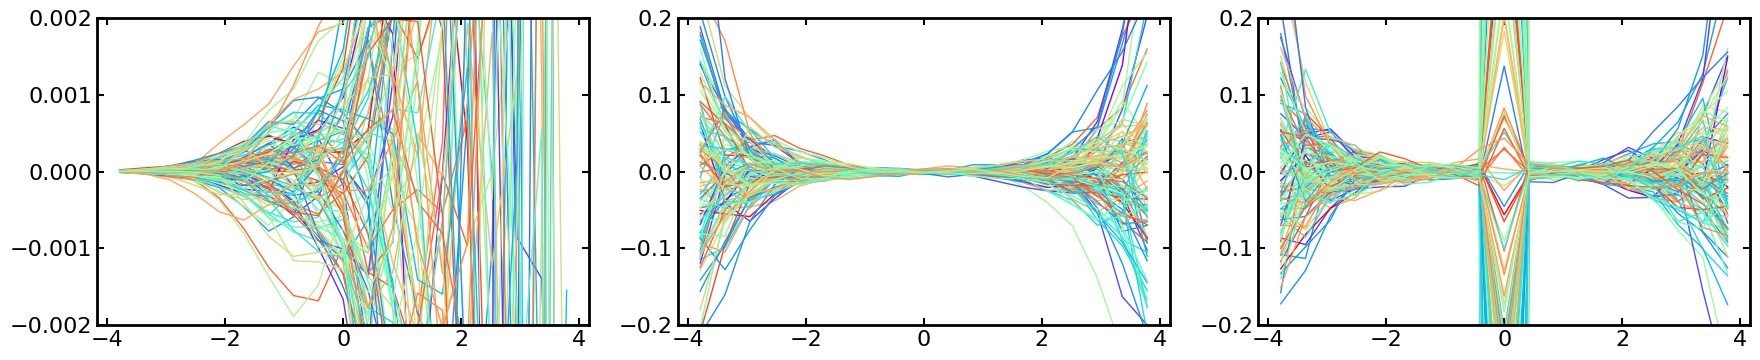

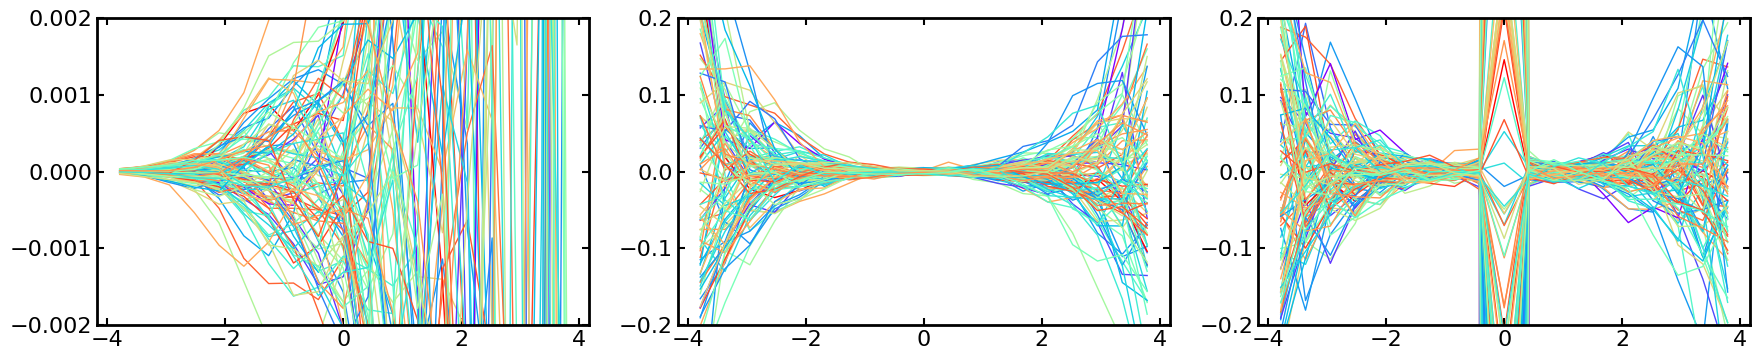

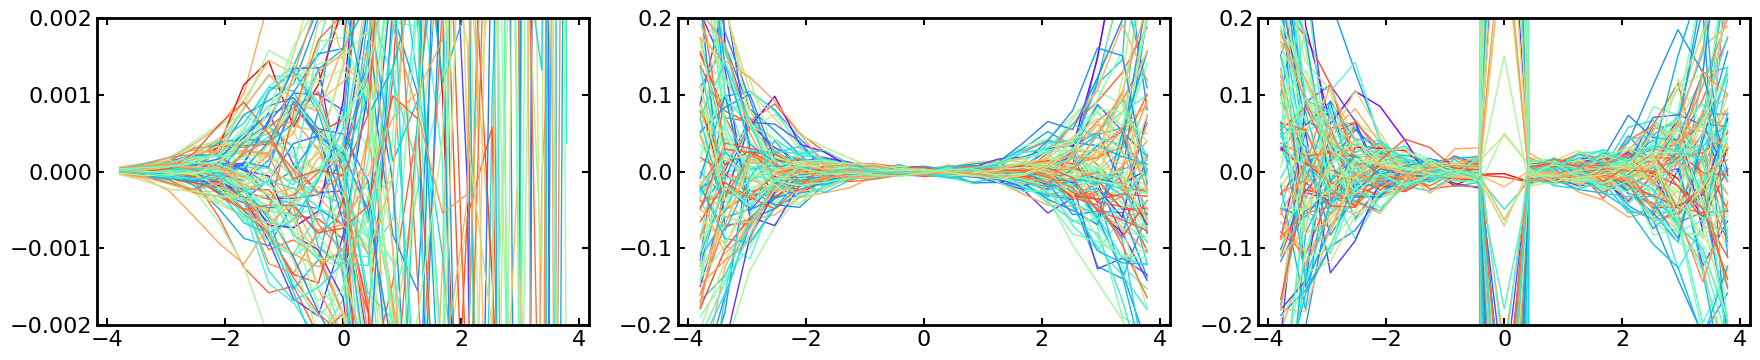

In [22]:


for theta in range(6):
    f,ax = plt.subplots(1,3,figsize=(18,4),sharex=True,sharey=False)
    for i in range(100):
        ax[0].plot(sn_bins,V0_z_thetas[theta][i]/ V0_zbins_thetas[zbin,theta,i,:] - 1,c=cm.rainbow(c_i[i]),ls='-',lw=1.0)
        ax[1].plot(sn_bins,V1_z_thetas[theta][i]/ V1_zbins_thetas[zbin,theta,i,:] - 1,c=cm.rainbow(c_i[i]),ls='-',lw=1.0)
        ax[2].plot(sn_bins,V2_z_thetas[theta][i]/ V2_zbins_thetas[zbin,theta,i,:] - 1,c=cm.rainbow(c_i[i]),ls='-',lw=1.0)
        ax[0].set_ylim(-0.002,0.002)
        ax[1].set_ylim(-0.2,0.2)
        ax[2].set_ylim(-0.2,0.2)
    #ax[0].set_ylabel('Relative residual')
    plt.tight_layout()
    #plt.savefig('/home/jarmijo/plots/MF_theta2_cosmo.jpg')

# zbin = 2 

<Figure size 640x480 with 0 Axes>

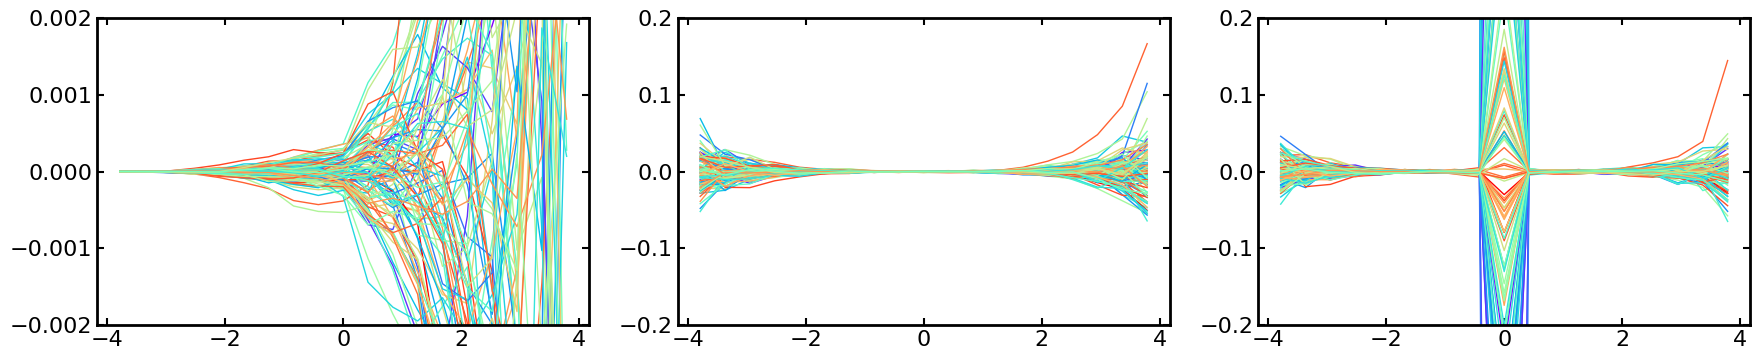

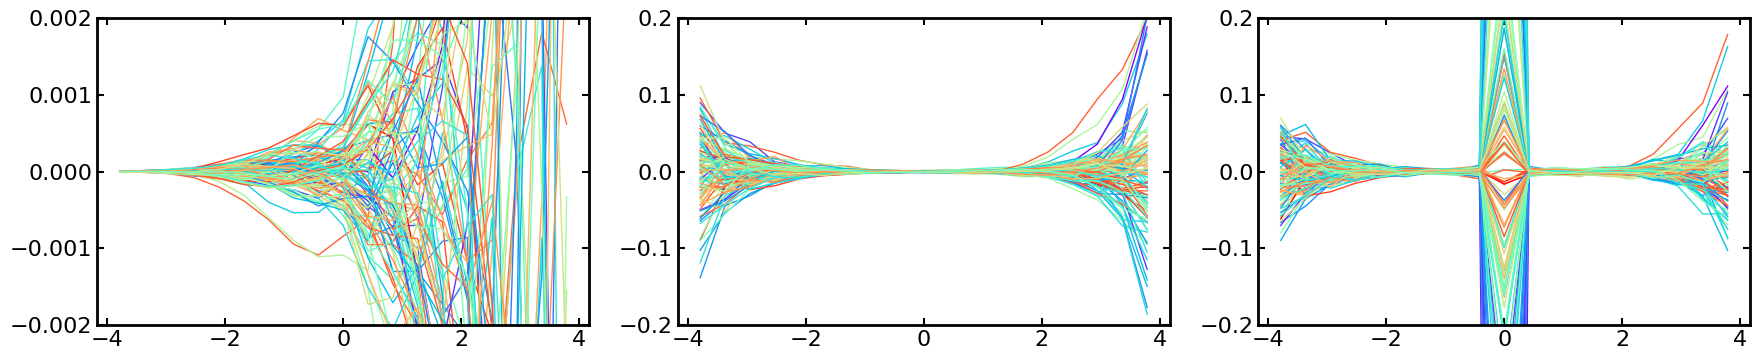

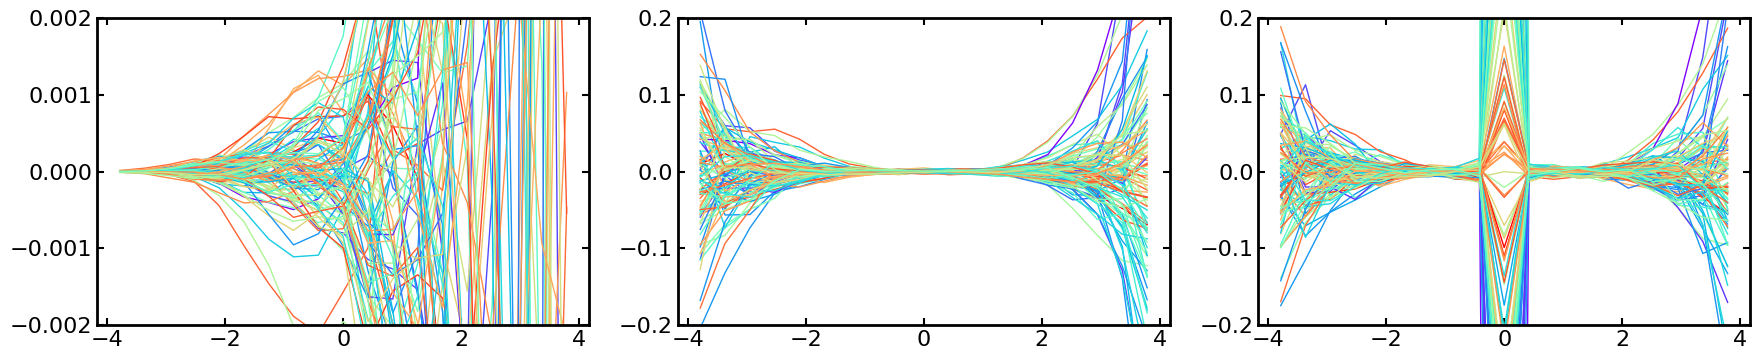

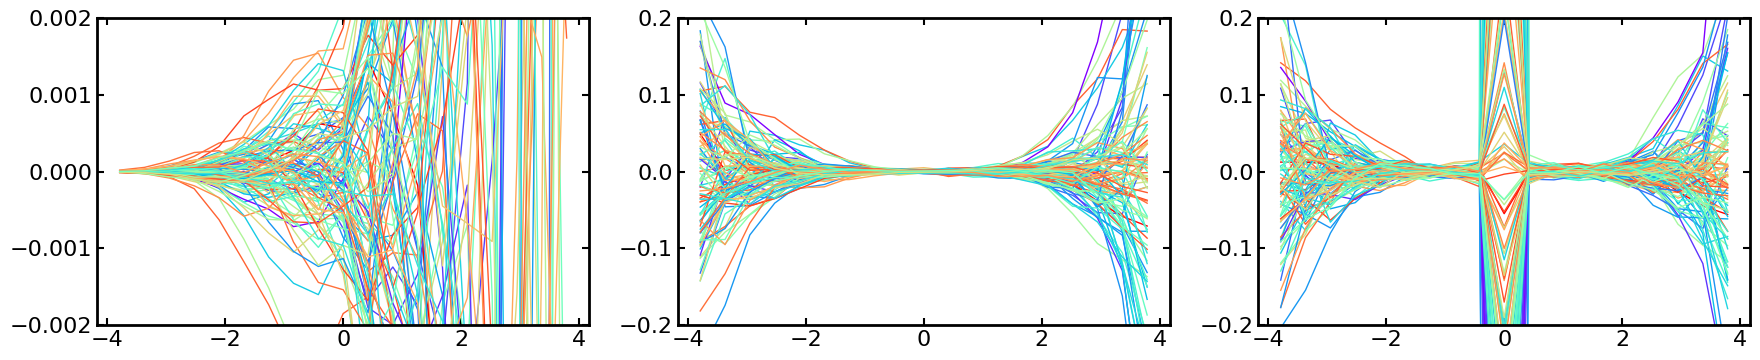

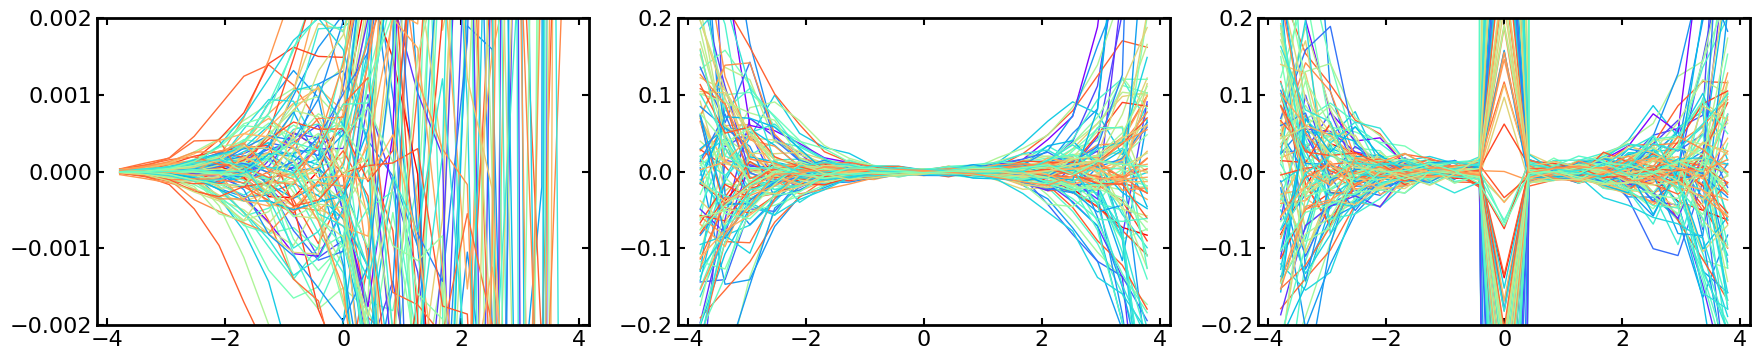

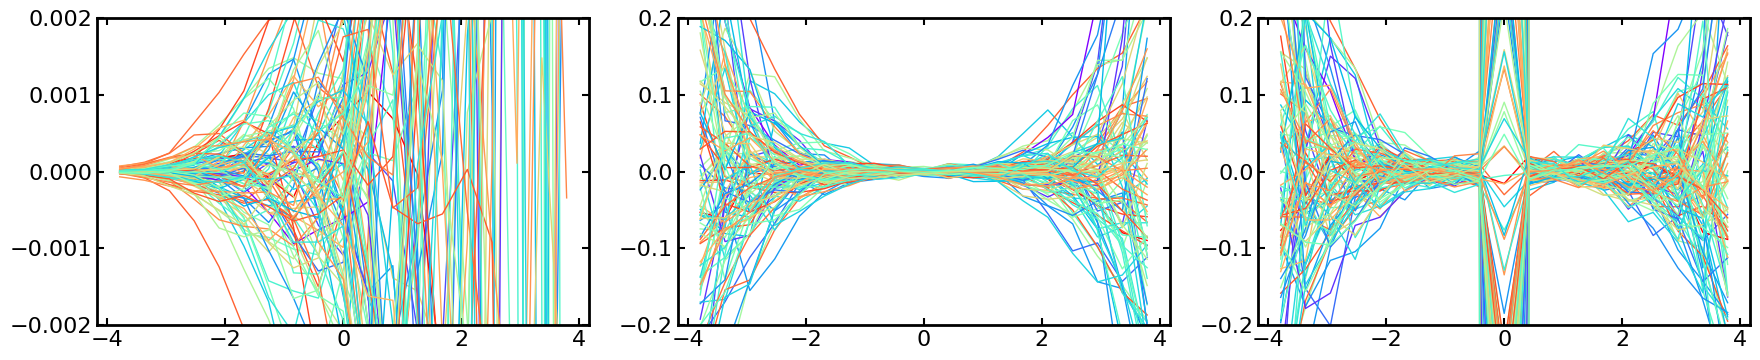

In [23]:
zbin = 1
V0_z_thetas = []
V1_z_thetas = []
V2_z_thetas = []
for theta in range(6):
    V0_z_theta = V0_zbins_thetas[zbin,theta,:,:]
    emu_test = emulator_GP(V0_z_theta,params=param_test)
    V0_z1_theta1_pred = np.zeros(V0_z_theta.shape)
    for i in range(len(param_test)):
        V0_z1_theta1_pred[i] = emu_test(param_test[i])
    V0_z_thetas.append(V0_z1_theta1_pred)
    
    V1_z_theta = V1_zbins_thetas[zbin,theta,:,:]
    emu_test = emulator_GP(V1_z_theta,params=param_test)
    V1_z1_theta1_pred = np.zeros(V0_z_theta.shape)
    for i in range(len(param_test)):
        V1_z1_theta1_pred[i] = emu_test(param_test[i])
    V1_z_thetas.append(V1_z1_theta1_pred)
    
    V2_z_theta = V2_zbins_thetas[zbin,theta,:,:]
    emu_test = emulator_GP(V2_z_theta,params=param_test)
    V2_z1_theta1_pred = np.zeros(V0_z_theta.shape)
    for i in range(len(param_test)):
        V2_z1_theta1_pred[i] = emu_test(param_test[i])
    V2_z_thetas.append(V2_z1_theta1_pred)
#
plt.tight_layout()
plt.show()
c_i = (c - c.min())/(c.max()-c.min())
norm_i = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())

for theta in range(6):
    f,ax = plt.subplots(1,3,figsize=(18,4),sharex=True,sharey=False)
    for i in range(100):
        ax[0].plot(sn_bins,V0_z_thetas[theta][i]/ V0_zbins_thetas[zbin,theta,i,:] - 1,c=cm.rainbow(c_i[i]),ls='-',lw=1.0)
        ax[1].plot(sn_bins,V1_z_thetas[theta][i]/ V1_zbins_thetas[zbin,theta,i,:] - 1,c=cm.rainbow(c_i[i]),ls='-',lw=1.0)
        ax[2].plot(sn_bins,V2_z_thetas[theta][i]/ V2_zbins_thetas[zbin,theta,i,:] - 1,c=cm.rainbow(c_i[i]),ls='-',lw=1.0)
        ax[0].set_ylim(-0.002,0.002)
        ax[1].set_ylim(-0.2,0.2)
        ax[2].set_ylim(-0.2,0.2)
    #ax[0].set_ylabel('Relative residual')
    plt.tight_layout()
    #plt.savefig('/home/jarmijo/plots/MF_theta2_cosmo.jpg')

# zbin = 3

<Figure size 640x480 with 0 Axes>

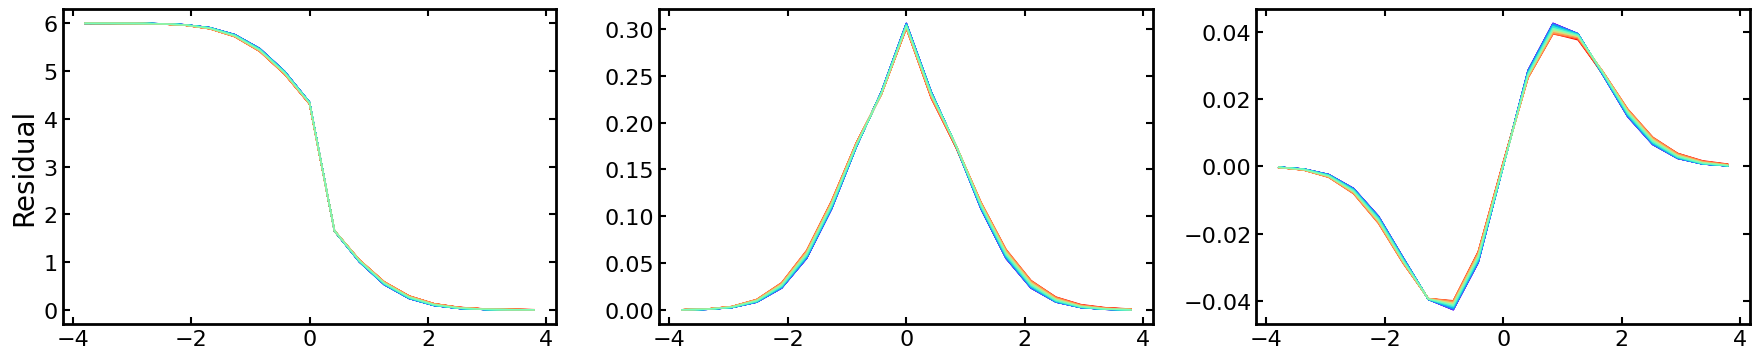

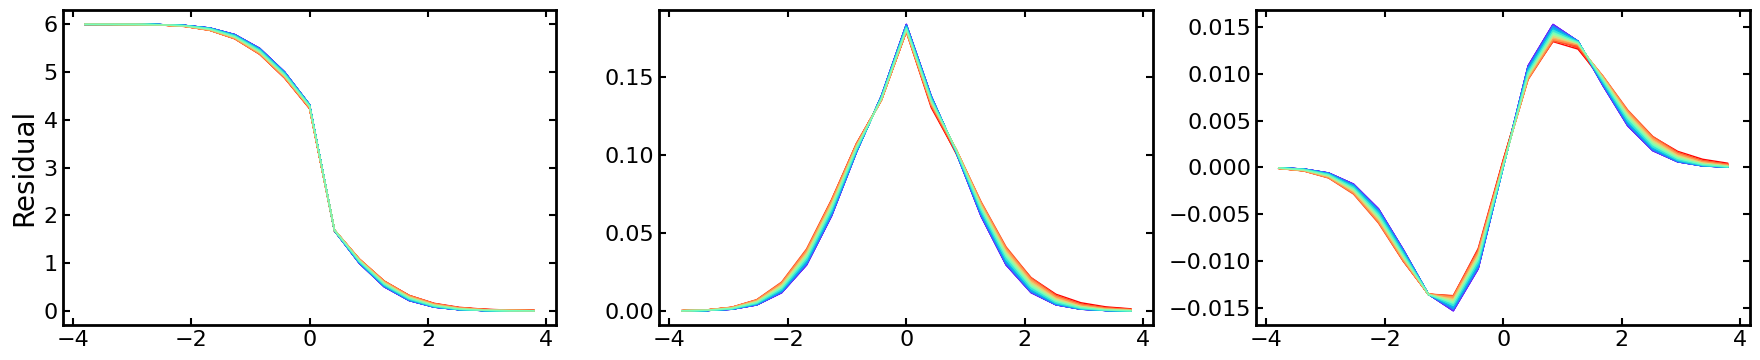

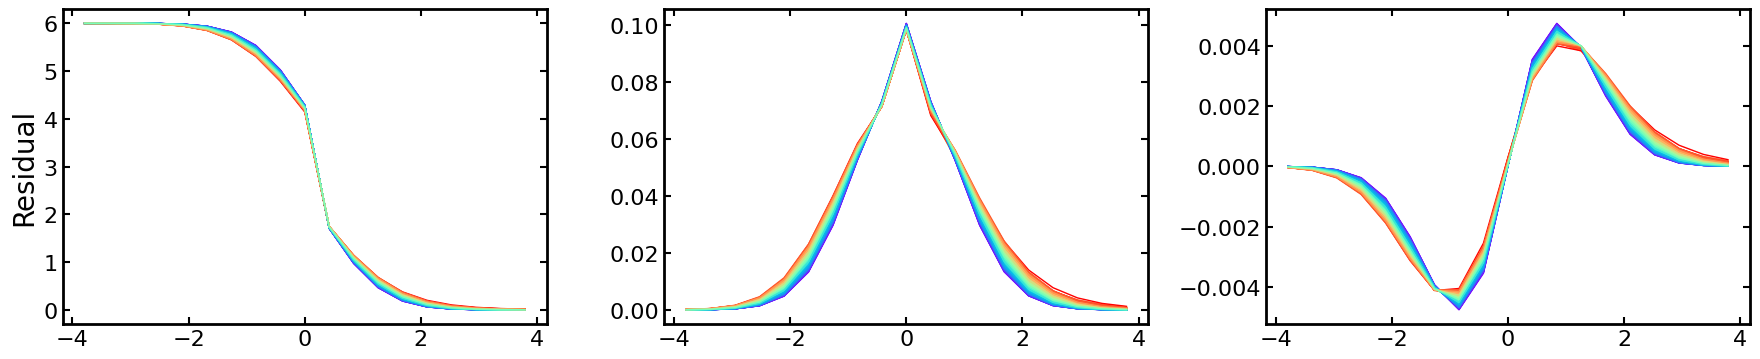

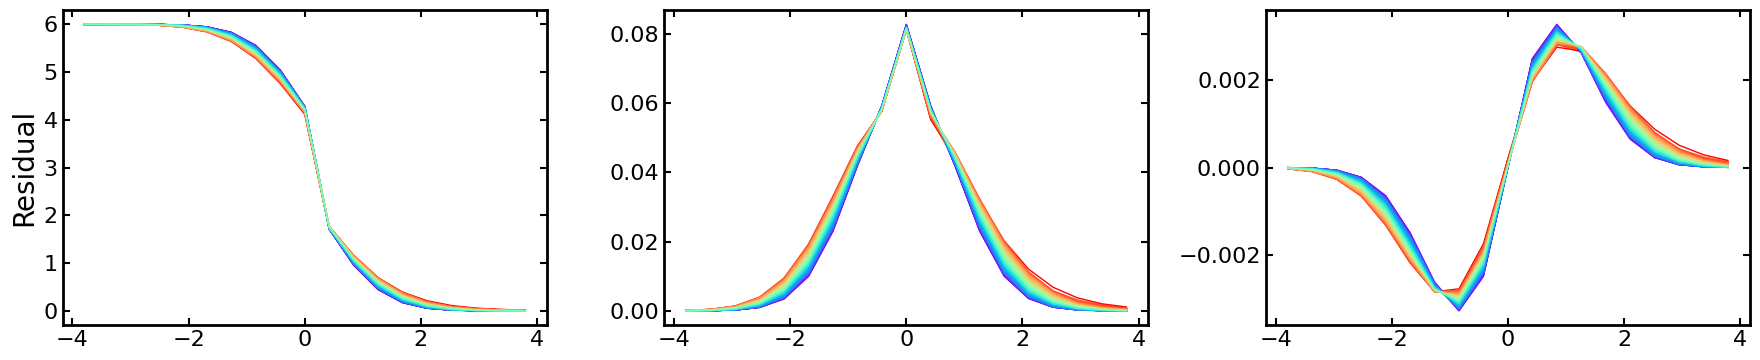

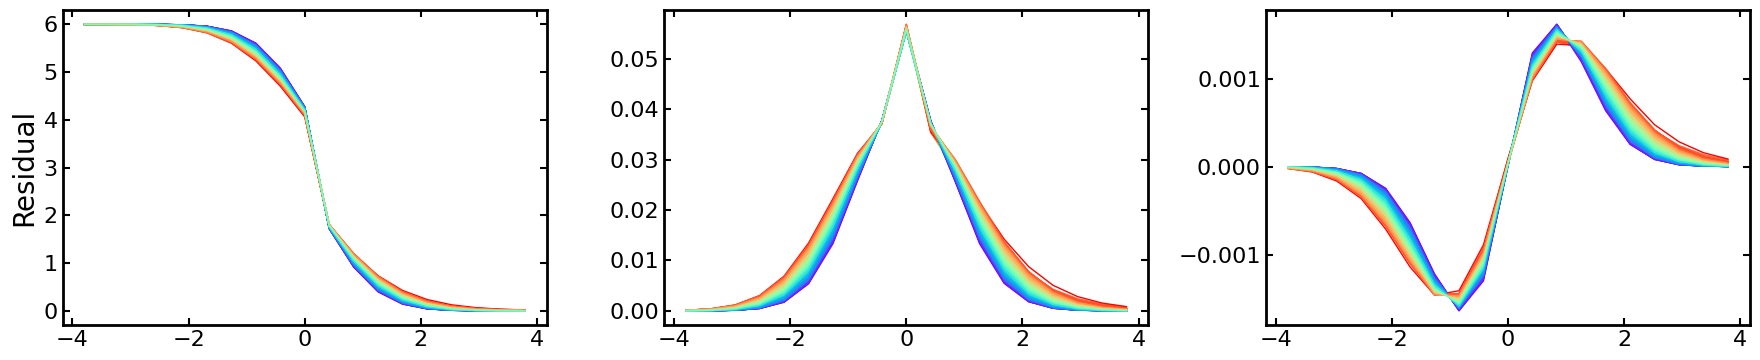

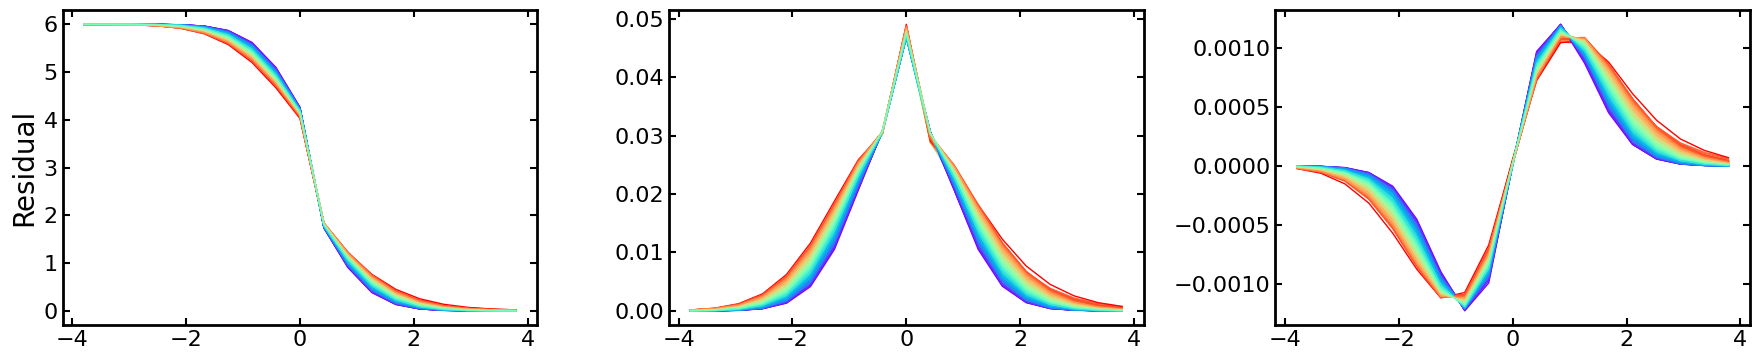

In [26]:
zbin = 2
V0_z_thetas = []
V1_z_thetas = []
V2_z_thetas = []
for theta in range(6):
    V0_z_theta = V0_zbins_thetas[zbin,theta,:,:]
    emu_test = emulator_GP(V0_z_theta,params=param_test)
    V0_z1_theta1_pred = np.zeros(V0_z_theta.shape)
    for i in range(len(param_test)):
        V0_z1_theta1_pred[i] = emu_test(param_test[i])
    V0_z_thetas.append(V0_z1_theta1_pred)
    
    V1_z_theta = V1_zbins_thetas[zbin,theta,:,:]
    emu_test = emulator_GP(V1_z_theta,params=param_test)
    V1_z1_theta1_pred = np.zeros(V0_z_theta.shape)
    for i in range(len(param_test)):
        V1_z1_theta1_pred[i] = emu_test(param_test[i])
    V1_z_thetas.append(V1_z1_theta1_pred)
    
    V2_z_theta = V2_zbins_thetas[zbin,theta,:,:]
    emu_test = emulator_GP(V2_z_theta,params=param_test)
    V2_z1_theta1_pred = np.zeros(V0_z_theta.shape)
    for i in range(len(param_test)):
        V2_z1_theta1_pred[i] = emu_test(param_test[i])
    V2_z_thetas.append(V2_z1_theta1_pred)
#
plt.tight_layout()
plt.show()
for theta in range(6):
    f,ax = plt.subplots(1,3,figsize=(18,4),sharex=True,sharey=False)
    for i in range(100):
        ax[0].plot(sn_bins,V0_z_thetas[theta][i],c=cm.rainbow(c_i[i]),ls='-',lw=1.0)
        ax[1].plot(sn_bins,V1_z_thetas[theta][i],c=cm.rainbow(c_i[i]),ls='-',lw=1.0)
        ax[2].plot(sn_bins,V2_z_thetas[theta][i],c=cm.rainbow(c_i[i]),ls='-',lw=1.0)
    ax[0].set_ylabel('Residual')
    plt.tight_layout()
    plt.show()

# zbin = 4

In [ ]:
zbin = 3
V0_z_thetas = []
V1_z_thetas = []
V2_z_thetas = []
for theta in range(6):
    V0_z_theta = V0_zbins_thetas[zbin,theta,:,:]
    emu_test = emulator_GP(V0_z_theta,params=param_test)
    V0_z1_theta1_pred = np.zeros(V0_z_theta.shape)
    for i in range(len(param_test)):
        V0_z1_theta1_pred[i] = emu_test(param_test[i])
    V0_z_thetas.append(V0_z1_theta1_pred)
    
    V1_z_theta = V1_zbins_thetas[zbin,theta,:,:]
    emu_test = emulator_GP(V1_z_theta,params=param_test)
    V1_z1_theta1_pred = np.zeros(V0_z_theta.shape)
    for i in range(len(param_test)):
        V1_z1_theta1_pred[i] = emu_test(param_test[i])
    V1_z_thetas.append(V1_z1_theta1_pred)
    
    V2_z_theta = V2_zbins_thetas[zbin,theta,:,:]
    emu_test = emulator_GP(V2_z_theta,params=param_test)
    V2_z1_theta1_pred = np.zeros(V0_z_theta.shape)
    for i in range(len(param_test)):
        V2_z1_theta1_pred[i] = emu_test(param_test[i])
    V2_z_thetas.append(V2_z1_theta1_pred)
#
plt.tight_layout()
plt.show()

for theta in range(6):
    f,ax = plt.subplots(1,3,figsize=(18,4),sharex=True,sharey=True)
    ax[0].plot(sn_bins,np.zeros_like(sn_bins),'k-',lw=2)
    ax[1].plot(sn_bins,np.zeros_like(sn_bins),'k-',lw=2)
    ax[1].plot(sn_bins,np.zeros_like(sn_bins),'k-',lw=2)
    for i in range(100):
        ax[0].plot(sn_bins,V0_z_thetas[theta][i]/V0_zbins_thetas[zbin,theta,i,:] - 1,'-')
        ax[1].plot(sn_bins,V1_z_thetas[theta][i]/V1_zbins_thetas[zbin,theta,i,:] - 1,'-')
        ax[2].plot(sn_bins,V2_z_thetas[theta][i]/V2_zbins_thetas[zbin,theta,i,:] - 1,'-')
    ax[0].set_ylim(-0.1,0.1)
    ax[0].set_ylabel('Relative residual')
    plt.tight_layout()
    plt.savefig('/home/jarmijo/plots/MF_zbin4_%d.jpg'%theta)

## Leave one out method

In [8]:
Oms = param_test[:,0]
S8s = param_test[:,1]*np.sqrt(param_test[:,0]/0.3)

In [9]:
cosmo_ids = np.arange(100).astype(int)

In [10]:
cosmo = 0 
V0_z_theta = V0_zbins_thetas[zbin,theta,~(cosmo_ids==cosmo),:]
emu_test = emulator_GP(V0_z_theta,params=param_test[~(cosmo_ids==cosmo)])
A = emu_test(param_test[cosmo])
bin_Ns = np.arange(19).astype(int)

In [11]:
zbin = 0
theta = 2 #fix one value of theta and do for 1 redshift bin
V0_z1_theta_cosmos = []
V1_z1_theta_cosmos = []
V2_z1_theta_cosmos = []

for cosmo in cosmo_ids:
    V0_z_theta = V0_zbins_thetas[zbin,theta,~(cosmo_ids==cosmo),:]
    emu_test = emulator_GP(V0_z_theta,params=param_test[~(cosmo_ids==cosmo)])
    V0_z_theta_cosmopred = emu_test(param_test[cosmo])
    V0_z1_theta_cosmos.append(V0_z_theta_cosmopred)
    
    V1_z_theta = V1_zbins_thetas[zbin,theta,~(cosmo_ids==cosmo),:]
    emu_test = emulator_GP(V1_z_theta,params=param_test[~(cosmo_ids==cosmo)])
    V1_z_theta_cosmopred = emu_test(param_test[cosmo])
    V1_z1_theta_cosmos.append(V1_z_theta_cosmopred)

    V2_z_theta = V2_zbins_thetas[zbin,theta,~(cosmo_ids==cosmo),:]
    emu_test = emulator_GP(V2_z_theta,params=param_test[~(cosmo_ids==cosmo)])
    V2_z_theta_cosmopred = emu_test(param_test[cosmo])
    V2_z1_theta_cosmos.append(V2_z_theta_cosmopred)

V0_z1_theta_cosmos = np.array(V0_z1_theta_cosmos)
V1_z1_theta_cosmos = np.array(V1_z1_theta_cosmos)
V2_z1_theta_cosmos = np.array(V2_z1_theta_cosmos)


In [ ]:

f,ax = plt.subplots(1,3,figsize=(16,4),sharex=True,sharey=True)
ax[0].plot(sn_bins,np.zeros_like(sn_bins),'k-',lw=2)
for i,cosmo in enumerate(cosmo_ids):
    ax[0].plot(sn_bins,V0_z1_theta_cosmos[i]/V0_zbins_thetas[zbin,theta,i,:] - 1,'-')
    ax[1].plot(sn_bins,V1_z1_theta_cosmos[i]/V1_zbins_thetas[zbin,theta,i,:] - 1,'-')
    ax[2].plot(sn_bins[~(bin_Ns==9)],V2_z1_theta_cosmos[i][~(bin_Ns==9)]/V2_zbins_thetas[zbin,theta,i,:][~(bin_Ns==9)] - 1,'-')
ax[0].set_ylim(-0.2,0.2)
ax[0].set_ylabel('Relative residuals')
ax[0].set_xlabel('S/N')
ax[1].set_xlabel('S/N')
ax[2].set_xlabel('S/N')
plt.tight_layout()
#plt.savefig('/home/jarmijo/MinkowskiFunctionals_HSC/Notebooks/imgs/MFs_emulator_accuracy.jpg',bbox_inches='tight')
plt.show()

In [12]:
zbin = 0
theta = 2 #fix one value of theta and do for 1 redshift bin
V0_z1_theta_cosmos = []
V1_z1_theta_cosmos = []
V2_z1_theta_cosmos = []

for cosmo in cosmo_ids:
    V0_z_theta = V0_zbins_thetas[zbin,theta,~(cosmo_ids==cosmo),:]
    emu_test = emulator_GP(V0_z_theta,params=param_test[~(cosmo_ids==cosmo)])
    V0_z_theta_cosmopred = emu_test(param_test[cosmo])
    V0_z1_theta_cosmos.append(V0_z_theta_cosmopred)
    
    V1_z_theta = V1_zbins_thetas[zbin,theta,~(cosmo_ids==cosmo),:]
    emu_test = emulator_GP(V1_z_theta,params=param_test[~(cosmo_ids==cosmo)])
    V1_z_theta_cosmopred = emu_test(param_test[cosmo])
    V1_z1_theta_cosmos.append(V1_z_theta_cosmopred)

    V2_z_theta = V2_zbins_thetas[zbin,theta,~(cosmo_ids==cosmo),:]
    emu_test = emulator_GP(V2_z_theta,params=param_test[~(cosmo_ids==cosmo)])
    V2_z_theta_cosmopred = emu_test(param_test[cosmo])
    V2_z1_theta_cosmos.append(V2_z_theta_cosmopred)

V0_z1_theta_cosmos = np.array(V0_z1_theta_cosmos)
V1_z1_theta_cosmos = np.array(V1_z1_theta_cosmos)
V2_z1_theta_cosmos = np.array(V2_z1_theta_cosmos)
#
#
zbin = 1
theta = 2 #fix one value of theta and do for 1 redshift bin
V0_z2_theta_cosmos = []
V1_z2_theta_cosmos = []
V2_z2_theta_cosmos = []

for cosmo in cosmo_ids:
    V0_z_theta = V0_zbins_thetas[zbin,theta,~(cosmo_ids==cosmo),:]
    emu_test = emulator_GP(V0_z_theta,params=param_test[~(cosmo_ids==cosmo)])
    V0_z_theta_cosmopred = emu_test(param_test[cosmo])
    V0_z2_theta_cosmos.append(V0_z_theta_cosmopred)
    
    V1_z_theta = V1_zbins_thetas[zbin,theta,~(cosmo_ids==cosmo),:]
    emu_test = emulator_GP(V1_z_theta,params=param_test[~(cosmo_ids==cosmo)])
    V1_z_theta_cosmopred = emu_test(param_test[cosmo])
    V1_z2_theta_cosmos.append(V1_z_theta_cosmopred)

    V2_z_theta = V2_zbins_thetas[zbin,theta,~(cosmo_ids==cosmo),:]
    emu_test = emulator_GP(V2_z_theta,params=param_test[~(cosmo_ids==cosmo)])
    V2_z_theta_cosmopred = emu_test(param_test[cosmo])
    V2_z2_theta_cosmos.append(V2_z_theta_cosmopred)

V0_z2_theta_cosmos = np.array(V0_z2_theta_cosmos)
V1_z2_theta_cosmos = np.array(V1_z2_theta_cosmos)
V2_z2_theta_cosmos = np.array(V2_z2_theta_cosmos)
#
#
zbin = 2
theta = 2 #fix one value of theta and do for 1 redshift bin
V0_z3_theta_cosmos = []
V1_z3_theta_cosmos = []
V2_z3_theta_cosmos = []

for cosmo in cosmo_ids:
    V0_z_theta = V0_zbins_thetas[zbin,theta,~(cosmo_ids==cosmo),:]
    emu_test = emulator_GP(V0_z_theta,params=param_test[~(cosmo_ids==cosmo)])
    V0_z_theta_cosmopred = emu_test(param_test[cosmo])
    V0_z3_theta_cosmos.append(V0_z_theta_cosmopred)
    
    V1_z_theta = V1_zbins_thetas[zbin,theta,~(cosmo_ids==cosmo),:]
    emu_test = emulator_GP(V1_z_theta,params=param_test[~(cosmo_ids==cosmo)])
    V1_z_theta_cosmopred = emu_test(param_test[cosmo])
    V1_z3_theta_cosmos.append(V1_z_theta_cosmopred)

    V2_z_theta = V2_zbins_thetas[zbin,theta,~(cosmo_ids==cosmo),:]
    emu_test = emulator_GP(V2_z_theta,params=param_test[~(cosmo_ids==cosmo)])
    V2_z_theta_cosmopred = emu_test(param_test[cosmo])
    V2_z3_theta_cosmos.append(V2_z_theta_cosmopred)

V0_z3_theta_cosmos = np.array(V0_z3_theta_cosmos)
V1_z3_theta_cosmos = np.array(V1_z3_theta_cosmos)
V2_z3_theta_cosmos = np.array(V2_z3_theta_cosmos)

In [13]:
V0_z1_residual = []
V0_z2_residual = []
V0_z3_residual = []
V1_z1_residual = []
V1_z2_residual = []
V1_z3_residual = []
V2_z1_residual = []
V2_z2_residual = []
V2_z3_residual = []

for i,cosmo in enumerate(cosmo_ids):
    zbin=0
    V0_z1_residual.append(np.abs(V0_z1_theta_cosmos[i]/V0_zbins_thetas[zbin,theta,i,:] - 1))
    V1_z1_residual.append(np.abs(V1_z1_theta_cosmos[i]/V1_zbins_thetas[zbin,theta,i,:] - 1))
    V2_z1_residual.append(np.abs(V2_z1_theta_cosmos[i][~(bin_Ns==9)]/V2_zbins_thetas[zbin,theta,i,:][~(bin_Ns==9)] - 1))
    zbin=1
    V0_z2_residual.append(np.abs(V0_z2_theta_cosmos[i]/V0_zbins_thetas[zbin,theta,i,:] - 1))
    V1_z2_residual.append(np.abs(V1_z2_theta_cosmos[i]/V1_zbins_thetas[zbin,theta,i,:] - 1))
    V2_z2_residual.append(np.abs(V2_z2_theta_cosmos[i][~(bin_Ns==9)]/V2_zbins_thetas[zbin,theta,i,:][~(bin_Ns==9)] - 1))
    zbin=2
    V0_z3_residual.append(np.abs(V0_z3_theta_cosmos[i]/V0_zbins_thetas[zbin,theta,i,:] - 1))
    V1_z3_residual.append(np.abs(V1_z3_theta_cosmos[i]/V1_zbins_thetas[zbin,theta,i,:] - 1))
    V2_z3_residual.append(np.abs(V2_z3_theta_cosmos[i][~(bin_Ns==9)]/V2_zbins_thetas[zbin,theta,i,:][~(bin_Ns==9)] - 1))

V0_z1_residual = np.array(V0_z1_residual)
V1_z1_residual = np.array(V1_z1_residual)
V2_z1_residual = np.array(V2_z1_residual)

V0_z2_residual = np.array(V0_z2_residual)
V1_z2_residual = np.array(V1_z2_residual)
V2_z2_residual = np.array(V2_z2_residual)

V0_z3_residual = np.array(V0_z3_residual)
V1_z3_residual = np.array(V1_z3_residual)
V2_z3_residual = np.array(V2_z3_residual)

In [14]:
V0_z1_color = np.mean(V0_z1_residual[:,:],axis=1)/0.055
V1_z1_color = np.mean(V1_z1_residual[:,:],axis=1)/0.055
V2_z1_color = np.mean(V2_z1_residual[:,:],axis=1)/0.055

V0_z2_color = np.mean(V0_z2_residual[:,:],axis=1)/0.055
V1_z2_color = np.mean(V1_z2_residual[:,:],axis=1)/0.055
V2_z2_color = np.mean(V2_z2_residual[:,:],axis=1)/0.055

V0_z3_color = np.mean(V0_z3_residual[:,:],axis=1)/0.055
V1_z3_color = np.mean(V1_z3_residual[:,:],axis=1)/0.055
V2_z3_color = np.mean(V2_z3_residual[:,:],axis=1)/0.055

In [15]:
norm_c = mpl.colors.Normalize(vmin=0.01, vmax=5.5)

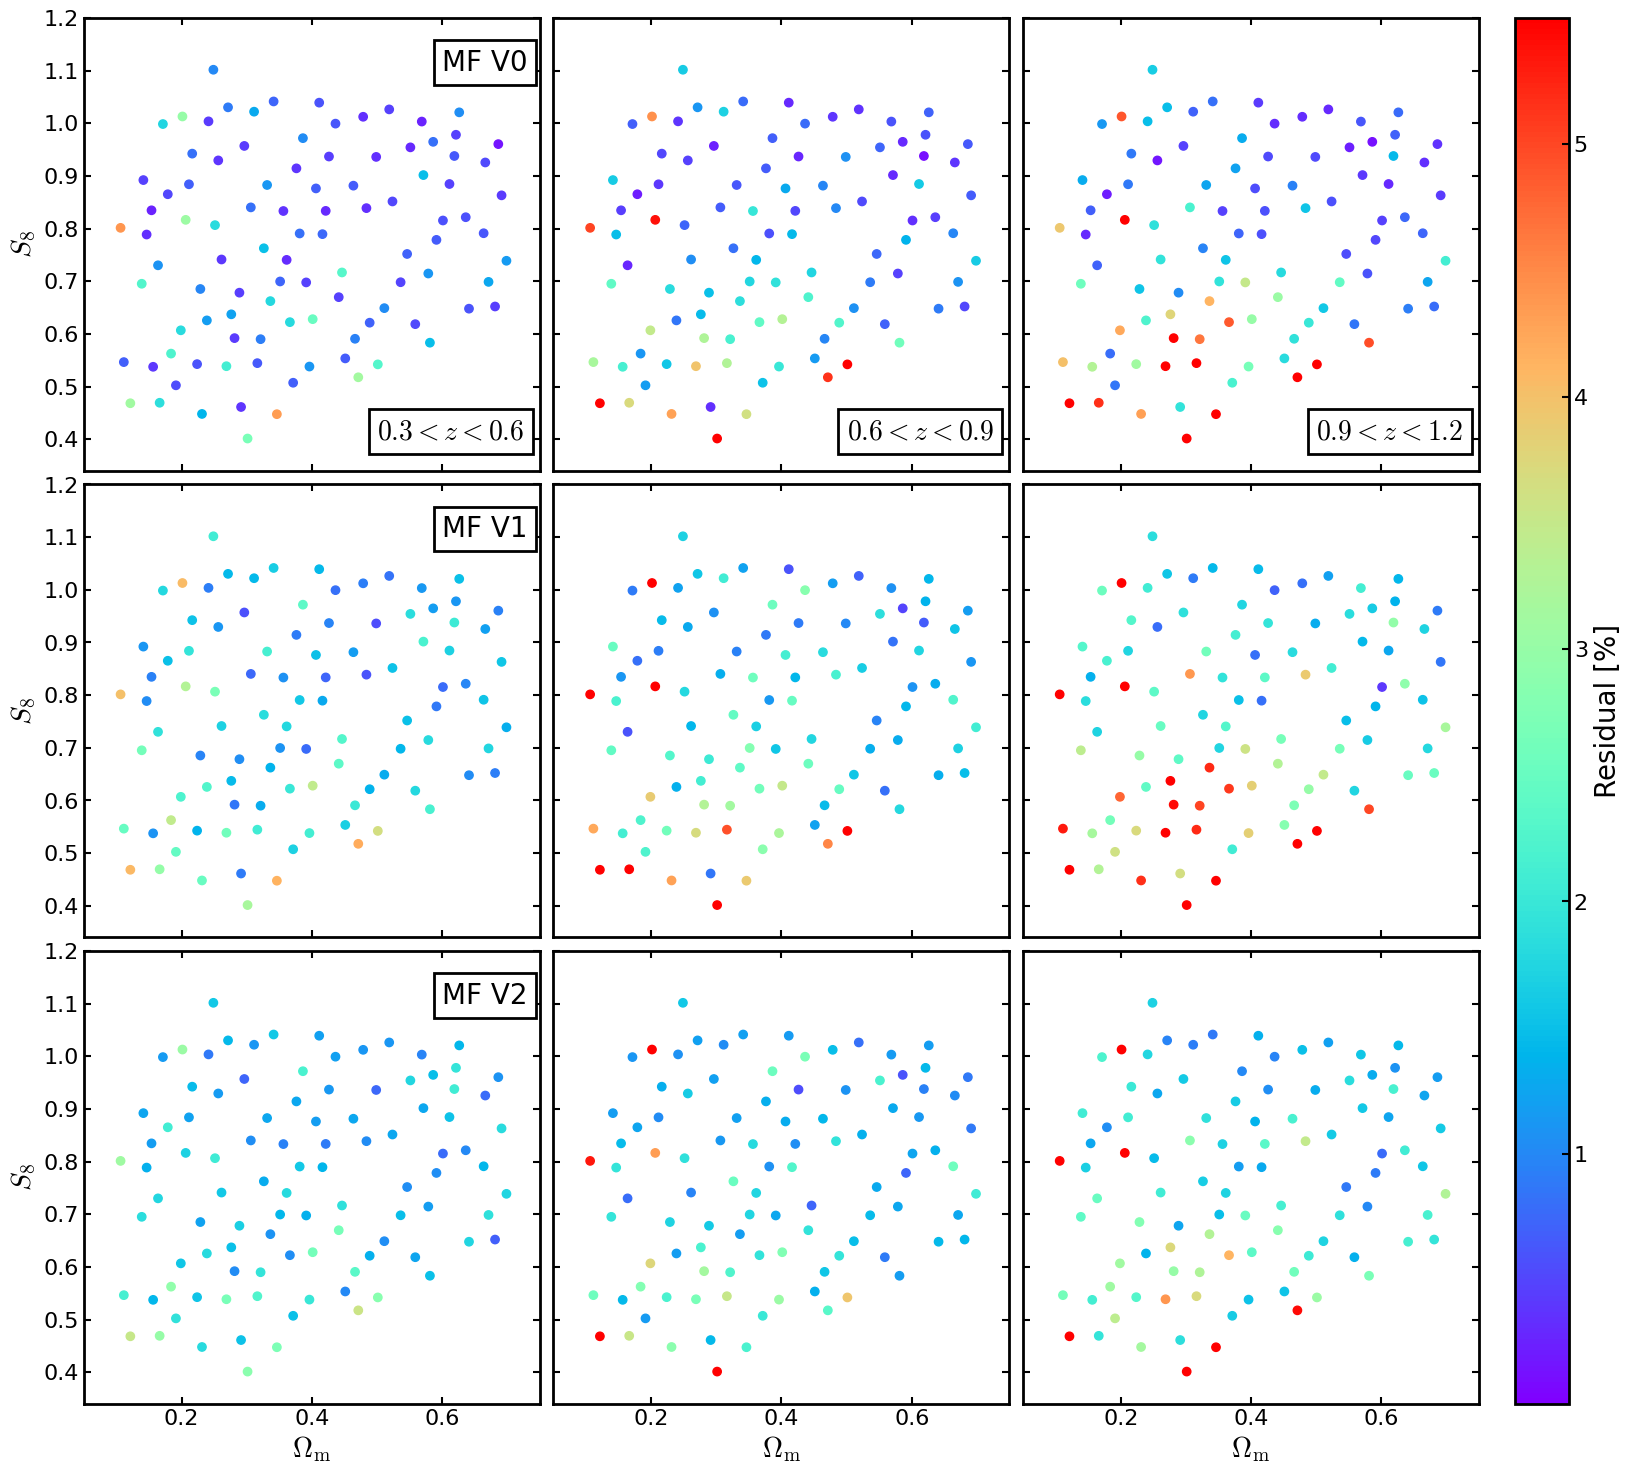

In [16]:
f,ax = plt.subplots(3,3,figsize=(18,18),sharex=True,sharey=True)
ax[0,0].scatter(Oms,S8s,c=cm.rainbow(V0_z1_color),marker='o')
ax[1,0].scatter(Oms,S8s,c=cm.rainbow(V1_z1_color),marker='o')
ax[2,0].scatter(Oms,S8s,c=cm.rainbow(V2_z1_color),marker='o')
ax[0,1].scatter(Oms,S8s,c=cm.rainbow(V0_z2_color),marker='o')
ax[1,1].scatter(Oms,S8s,c=cm.rainbow(V1_z2_color),marker='o')
ax[2,1].scatter(Oms,S8s,c=cm.rainbow(V2_z2_color),marker='o')
ax[0,2].scatter(Oms,S8s,c=cm.rainbow(V0_z3_color),marker='o')
ax[1,2].scatter(Oms,S8s,c=cm.rainbow(V1_z3_color),marker='o')
ax[2,2].scatter(Oms,S8s,c=cm.rainbow(V2_z3_color),marker='o')
ax[0,0].set_xlim(0.05,0.75)
ax[0,0].set_ylim(0.34,1.2)
ax[2,0].set_xlabel(r'$\Omega_{\rm m}$')
ax[2,1].set_xlabel(r'$\Omega_{\rm m}$')
ax[2,2].set_xlabel(r'$\Omega_{\rm m}$')
ax[0,0].set_ylabel(r'$S_8$')
ax[1,0].set_ylabel(r'$S_8$')
ax[2,0].set_ylabel(r'$S_8$')
cbaxes = f.add_axes([0.92, 0.11, 0.03, 0.77]) 
b1 = plt.colorbar(cm.ScalarMappable(norm=norm_c,cmap=mpl.colormaps['rainbow'],),ax=ax,cax=cbaxes)
b1.set_label('Residual [%]')
plt.subplots_adjust(hspace=0.03,wspace=0.03)
ax[0,0].text(0.6,1.1,'MF V0',bbox=dict(boxstyle="square",fc=(1,1,1),lw=2))
ax[1,0].text(0.6,1.1,'MF V1',bbox=dict(boxstyle="square",fc=(1,1,1),lw=2))
ax[2,0].text(0.6,1.1,'MF V2',bbox=dict(boxstyle="square",fc=(1,1,1),lw=2))
ax[0,0].text(0.5,0.4,r'$0.3 < z < 0.6$',bbox=dict(boxstyle="square",fc=(1,1,1),lw=2))
ax[0,1].text(0.5,0.4,r'$0.6 < z < 0.9$',bbox=dict(boxstyle="square",fc=(1,1,1),lw=2))
ax[0,2].text(0.5,0.4,r'$0.9 < z < 1.2$',bbox=dict(boxstyle="square",fc=(1,1,1),lw=2))
plt.savefig('/home/jarmijo/MinkowskiFunctionals_HSC/Notebooks/imgs/emulator_accuracy.png',bbox_inches='tight')
plt.show()

In [17]:
V0_z1_color = np.mean(V0_z1_residual[:,:17],axis=1)/0.055
V1_z1_color = np.mean(V1_z1_residual[:,1:18],axis=1)/0.055
V2_z1_color = np.mean(V2_z1_residual[:,1:18],axis=1)/0.055

V0_z2_color = np.mean(V0_z2_residual[:,:17],axis=1)/0.055
V1_z2_color = np.mean(V1_z2_residual[:,1:18],axis=1)/0.055
V2_z2_color = np.mean(V2_z2_residual[:,1:18],axis=1)/0.055

V0_z3_color = np.mean(V0_z3_residual[:,:17],axis=1)/0.055
V1_z3_color = np.mean(V1_z3_residual[:,1:18],axis=1)/0.055
V2_z3_color = np.mean(V2_z3_residual[:,1:18],axis=1)/0.055

In [18]:
norm_c = mpl.colors.Normalize(vmin=0.01, vmax=5.5)

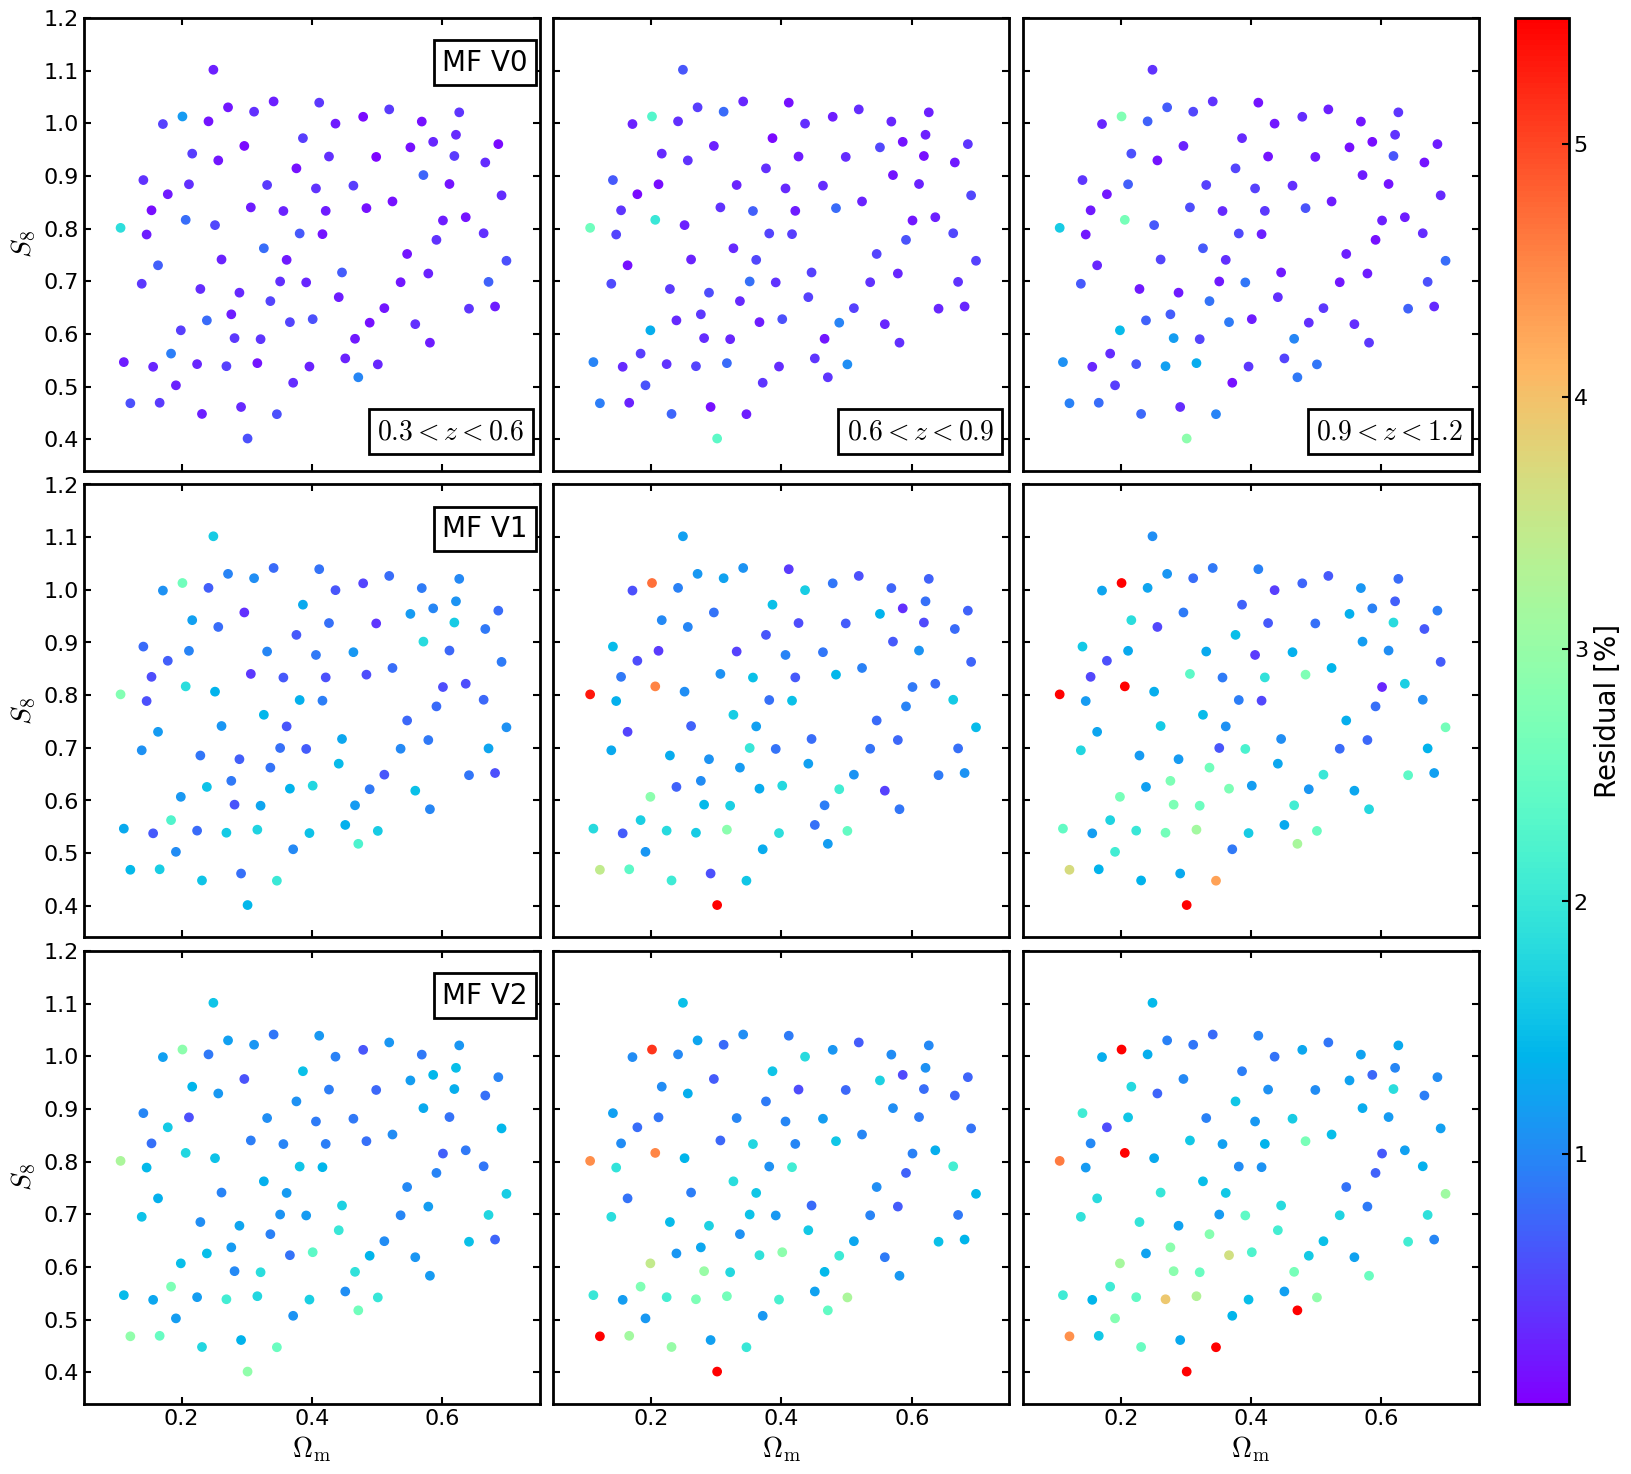

In [19]:
f,ax = plt.subplots(3,3,figsize=(18,18),sharex=True,sharey=True)
ax[0,0].scatter(Oms,S8s,c=cm.rainbow(V0_z1_color),marker='o')
ax[1,0].scatter(Oms,S8s,c=cm.rainbow(V1_z1_color),marker='o')
ax[2,0].scatter(Oms,S8s,c=cm.rainbow(V2_z1_color),marker='o')
ax[0,1].scatter(Oms,S8s,c=cm.rainbow(V0_z2_color),marker='o')
ax[1,1].scatter(Oms,S8s,c=cm.rainbow(V1_z2_color),marker='o')
ax[2,1].scatter(Oms,S8s,c=cm.rainbow(V2_z2_color),marker='o')
ax[0,2].scatter(Oms,S8s,c=cm.rainbow(V0_z3_color),marker='o')
ax[1,2].scatter(Oms,S8s,c=cm.rainbow(V1_z3_color),marker='o')
ax[2,2].scatter(Oms,S8s,c=cm.rainbow(V2_z3_color),marker='o')
ax[0,0].set_xlim(0.05,0.75)
ax[0,0].set_ylim(0.34,1.2)
ax[2,0].set_xlabel(r'$\Omega_{\rm m}$')
ax[2,1].set_xlabel(r'$\Omega_{\rm m}$')
ax[2,2].set_xlabel(r'$\Omega_{\rm m}$')
ax[0,0].set_ylabel(r'$S_8$')
ax[1,0].set_ylabel(r'$S_8$')
ax[2,0].set_ylabel(r'$S_8$')
cbaxes = f.add_axes([0.92, 0.11, 0.03, 0.77]) 
b1 = plt.colorbar(cm.ScalarMappable(norm=norm_c,cmap=mpl.colormaps['rainbow'],),ax=ax,cax=cbaxes)
b1.set_label('Residual [%]')
plt.subplots_adjust(hspace=0.03,wspace=0.03)
ax[0,0].text(0.6,1.1,'MF V0',bbox=dict(boxstyle="square",fc=(1,1,1),lw=2))
ax[1,0].text(0.6,1.1,'MF V1',bbox=dict(boxstyle="square",fc=(1,1,1),lw=2))
ax[2,0].text(0.6,1.1,'MF V2',bbox=dict(boxstyle="square",fc=(1,1,1),lw=2))
ax[0,0].text(0.5,0.4,r'$0.3 < z < 0.6$',bbox=dict(boxstyle="square",fc=(1,1,1),lw=2))
ax[0,1].text(0.5,0.4,r'$0.6 < z < 0.9$',bbox=dict(boxstyle="square",fc=(1,1,1),lw=2))
ax[0,2].text(0.5,0.4,r'$0.9 < z < 1.2$',bbox=dict(boxstyle="square",fc=(1,1,1),lw=2))
plt.savefig('/home/jarmijo/MinkowskiFunctionals_HSC/Notebooks/imgs/emulator_accuracy_scalecuts.png',bbox_inches='tight')

plt.show()

## Testing covariance

In [22]:
V0_z1_theta_cosmos.shape,V0_zbins_thetas.shape

((100, 19), (4, 6, 100, 19))